<a href="https://colab.research.google.com/github/omartinez182/510-Startup-Project/blob/main/Colab_Notebook/510_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 510 Project

## Imports

In [ ]:
!pip install pytrends
!pip install shap

In [ ]:
import pandas as pd
import numpy as np
import datetime

# Plotting
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from scipy import stats
import lightgbm as lgb
from scipy.misc import derivative

# Interpretability
import shap
# print the JS visualization code to the notebook
shap.initjs()
# Trends API
from pytrends.request import TrendReq
import urllib.request
from bs4 import BeautifulSoup
import statsmodels.api as sm
from statsmodels.formula.api import ols

import pickle

## Pre-processing

#### Primary Data Sources

In [ ]:
#URL_cb = 'https://raw.githubusercontent.com/omartinez182/510-Startup-Project/main/Data/primary_data.csv'
clean_cb = pd.read_csv('primary_data.csv', parse_dates=['funding_rounds', 'founded_at', 'first_funding_at','last_funding_at'])

#[0, 1, 2, 3] = ['acquired', 'closed', 'ipo', 'operating']
# Drop companies that are closed
#clean_cb = clean_cb[clean_cb.status != '1']

# Consolidate companies that had an exit under a single category
#clean_cb.loc[:,'status'] = [1 if x < 3 else 0 for x in clean_cb.status] #1 = company had an exit, 0 = still operating (no exit)

# We'll only look at companies that had their first funding round in the year 2000 and beyond
date_filter = datetime.datetime(2004,1,1)
clean_cb = clean_cb[clean_cb.first_funding_at >= date_filter]

# Select only companies in the US
clean_cb = clean_cb[clean_cb.country_code == 'USA']

# Extract the year of first funding
clean_cb['first_funding_year'] = pd.to_datetime(clean_cb.first_funding_at.dt.year, format='%Y')

# Drop all columns with no founding year
clean_cb.dropna(subset=['founded_at'], inplace=True)

clean_cb.info()

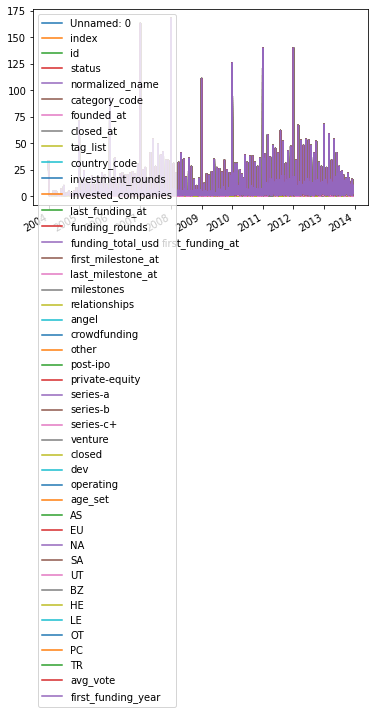

In [ ]:
# Distribution of companies by year of first round of funding
clean_cb.groupby(by='first_funding_at').count().plot()

#### Web Scraping (GDP Data)

In [ ]:
URL = 'https://www.macrotrends.net/countries/USA/united-states/gdp-growth-rate'
header = { 'User-Agent' : 'Mozilla/5.0 (Windows NT 6.1; Win64; x64)' }

# Define request
req = urllib.request.Request(URL, headers=header)
response = urllib.request.urlopen(req)
soup = BeautifulSoup(response, 'lxml')
prettyHTML = soup.prettify() 
td = list(soup.findAll('td'))

# Extract relevant elements
gdp_year = [string if ('<td style="text-align:center">' in str(string)) | ('<td style="text-align:center;">' in str(string)) else "" for string in td]
gdp_year = [i for i in gdp_year if i]

# Clean the list
gdp_year_clean = []
for s in gdp_year:
  s = str(s)
  start = s.find('>')+1
  end = s.find('<', start)
  s = s[start:end]
  gdp_year_clean.append(s)

# Create pairs of data points and extract year
years = gdp_year_clean[::3].copy()
gdp_year_clean = [string if '%' in str(string) else "" for string in gdp_year_clean]
gdp_year_clean = [i for i in gdp_year_clean if i]       
gdp_growth = gdp_year_clean[::2].copy()
annual_change = gdp_year_clean[1::2].copy()

# Create a dataframe with the data
gdp_df = pd.DataFrame({"Year":years, "GDP_Growth":gdp_growth, "GDP_Annual_Change":annual_change})
gdp_df['Year'] = pd.to_datetime(gdp_df.Year,format='%Y')
gdp_df['GDP_Growth'] = gdp_df.GDP_Growth.str.replace("%","").astype('float')
gdp_df['GDP_Annual_Change'] = gdp_df.GDP_Annual_Change.str.replace("%","").astype('float')
gdp_df

,Year,GDP_Growth,GDP_Annual_Change
0,2020-01-01,-3.49,-5.65
1,2019-01-01,2.16,-0.84
2,2018-01-01,3.00,0.66
3,2017-01-01,2.33,0.62
4,2016-01-01,1.71,-1.36
5,2015-01-01,3.08,0.55
6,2014-01-01,2.53,0.68
7,2013-01-01,1.84,-0.41
8,2012-01-01,2.25,0.70
9,2011-01-01,1.55,-1.01


#### Join Primary & GDP Data

In [ ]:
# Merge clean CB data with GDP data
df_clean_cb_gdp = clean_cb.merge(gdp_df, how='left', left_on='first_funding_year', right_on='Year').copy()
df_clean_cb_gdp.drop(['Year'], axis=1, inplace=True)
df_clean_cb_gdp.head(2)

,Unnamed: 0,index,id,status,normalized_name,category_code,founded_at,closed_at,tag_list,country_code,investment_rounds,invested_companies,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,relationships,angel,crowdfunding,other,post-ipo,private-equity,series-a,series-b,series-c+,venture,closed,dev,operating,age_set,AS,EU,NA,SA,UT,BZ,HE,LE,OT,PC,TR,avg_vote,first_funding_year,GDP_Growth,GDP_Annual_Change
0,0,0,c:1,3,wetpaint,web,2005-10-17,NaN,"wiki, seattle, elowitz, media-industry, media-...",USA,0,0,2005-10-01,2008-05-19,3,39750000.0,2010-09-05,2013-09-18,5,17,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,66.00,2005-01-01,3.51,-0.29
1,1,1,c:1001,0,friendfeed,web,2007-10-01,NaN,"socialnetwork, newsfeed, socialnetworkaggregator",USA,0,0,2008-02-26,2008-02-26,1,5000000.0,2008-05-01,2012-09-13,3,14,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,61.25,2008-01-01,-0.14,-2.01


#### Google Trends API

In [ ]:
# Connect to API
pytrends = TrendReq(hl='en-US', tz=360) 

# Build Payload
kw_list = ["startups"] # List of keywords to get data 
pytrends.build_payload(kw_list, geo='US', timeframe='2004-01-01 2014-12-31') 

# Get interest over Time
rsi_data = pytrends.interest_over_time() 
rsi_data = rsi_data.reset_index() 
rsi_data = rsi_data.rename(columns={"startups": "Search Interest for Startups"})

fig = px.line(rsi_data, x="date", y='Search Interest for Startups', title='Keyword Web Search Interest Over Time')
fig.show() 
print(rsi_data)

          date  Search Interest for Startups  isPartial
0   2004-01-01                            84      False
1   2004-02-01                            62      False
2   2004-03-01                            32      False
3   2004-04-01                            42      False
4   2004-05-01                            39      False
..         ...                           ...        ...
127 2014-08-01                            93      False
128 2014-09-01                            91      False
129 2014-10-01                           100      False
130 2014-11-01                            87      False
131 2014-12-01                            83      False

[132 rows x 3 columns]


In [ ]:
# Round down date to the first day of the month
df_clean_cb_gdp['first_funding_at_round'] = df_clean_cb_gdp.first_funding_at.to_numpy().astype('datetime64[M]')

# Join primary df with RSI data
df_clean_cb_gdp_rsi = df_clean_cb_gdp.merge(rsi_data, how='left', left_on='first_funding_at_round', right_on='date')
df_clean_cb_gdp_rsi['Search Interest for Startups'].fillna(0, inplace=True) # If there's no data it means RSI was 0 at that time, therefore, we use 0 to impute NaNs
df_clean_cb_gdp_rsi.drop(['date','isPartial'], axis=1, inplace=True)

In [ ]:
df_clean_cb_gdp_rsi.head(5)

,Unnamed: 0,index,id,status,normalized_name,category_code,founded_at,closed_at,tag_list,country_code,investment_rounds,invested_companies,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,relationships,angel,crowdfunding,other,post-ipo,private-equity,series-a,series-b,series-c+,venture,closed,dev,operating,age_set,AS,EU,NA,SA,UT,BZ,HE,LE,OT,PC,TR,avg_vote,first_funding_year,GDP_Growth,GDP_Annual_Change,first_funding_at_round,Search Interest for Startups
0,0,0,c:1,3,wetpaint,web,2005-10-17,NaN,"wiki, seattle, elowitz, media-industry, media-...",USA,0,0,2005-10-01,2008-05-19,3,39750000.0,2010-09-05,2013-09-18,5,17,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,66.00,2005-01-01,3.51,-0.29,2005-10-01,13
1,1,1,c:1001,0,friendfeed,web,2007-10-01,NaN,"socialnetwork, newsfeed, socialnetworkaggregator",USA,0,0,2008-02-26,2008-02-26,1,5000000.0,2008-05-01,2012-09-13,3,14,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,61.25,2008-01-01,-0.14,-2.01,2008-02-01,34
2,2,2,c:10014,0,mobclix,mobile,2008-03-01,NaN,"techcrunch50, tc50, iphone, analytics, free-de...",USA,0,0,2008-09-01,2008-09-01,1,0.0,1995-03-01,2012-09-18,4,9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,63.25,2008-01-01,-0.14,-2.01,2008-09-01,31
3,3,3,c:10015,3,fitbit,health,2007-10-01,NaN,"techcrunch50, tc50, health, hardware, fitness,...",USA,0,0,2008-10-10,2013-08-13,5,68069200.0,NaN,NaN,0,14,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,86.00,2008-01-01,-0.14,-2.01,2008-10-01,30
4,4,4,c:100155,3,mtpv,cleantech,2003-01-01,NaN,NaN,USA,0,0,2011-03-08,2012-01-26,3,10125293.0,2010-01-01,2010-01-01,1,6,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.00,2011-01-01,1.55,-1.01,2011-03-01,46


#### Feature Engineering

In [ ]:
# Calculate time to first funding
df_clean_cb_gdp_rsi['time_to_funding'] = (df_clean_cb_gdp_rsi.first_funding_at - df_clean_cb_gdp_rsi.founded_at).dt.days.astype('int')

# Drop duplicate companies
df_clean_cb_gdp_rsi.normalized_name.nunique()
df_clean_cb_gdp_rsi.drop_duplicates(subset=['normalized_name'], inplace=True)

# Convert founding rounds to int
df_clean_cb_gdp_rsi.funding_rounds = df_clean_cb_gdp_rsi.funding_rounds.astype('int')

# Drop irrelevant columns (dates have been used for other representations, so they are no longer necessary)
# Also, because our focus is only for US based companies, we don't need the continents or country code
df_clean_cb_gdp_rsi.drop(['Unnamed: 0','index', 'id', 'normalized_name','founded_at','closed_at','tag_list',
                          'first_milestone_at','last_milestone_at','first_funding_year','first_funding_at_round',
                          'first_funding_at','last_funding_at','avg_vote','closed','AS','EU','NA','SA','UT', 
                          'BZ','HE','LE','OT','PC','TR','country_code'], axis=1, inplace=True)

In [ ]:
df_clean_cb_gdp_rsi.head()

,status,category_code,investment_rounds,invested_companies,funding_rounds,funding_total_usd,milestones,relationships,angel,crowdfunding,other,post-ipo,private-equity,series-a,series-b,series-c+,venture,dev,operating,age_set,GDP_Growth,GDP_Annual_Change,Search Interest for Startups,time_to_funding
0,3,web,0,0,3,39750000.0,5,17,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,2.0,3.51,-0.29,13,-16
1,0,web,0,0,1,5000000.0,3,14,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,-0.14,-2.01,34,148
2,0,mobile,0,0,1,0.0,4,9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,-0.14,-2.01,31,184
3,3,health,0,0,5,68069200.0,0,14,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0,2.0,-0.14,-2.01,30,375
4,3,cleantech,0,0,3,10125293.0,1,6,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,2.0,1.55,-1.01,46,2988


## Exploratory Analysis

To provide additional insights to the user, we'll calculate some descriptive statistics for the selected industry/company status.

### Metrics by Status

In [ ]:
# Creating a new feature to generalize the category code
leisure = ['games_video', 'photo_video', 'social', 'hospitality', 'sports', 'fashion', 'messaging', 'music']
bizsupport = ['network_hosting', 'advertising', 'enterprise', 'consulting', 'analytics', 'public_relations', 'security', 'legal']
building = ['cleantech', 'manufacturing', 'semiconductor', 'automotive', 'real_eastate', 'nanotech']
petcare = ['pets']
travel = ['travel', 'transportation']
health = ['health', 'medical', 'biotech']
tech = ['web','mobile','software','ecommerce']
other = ['other', 'finance', 'education', 'search', 'hardware', 'news', 'government', 'nonprofit', 'local']

In [ ]:
# Load permalinks for each company
ids = pd.read_csv("permalinks.csv")

In [ ]:
# Status Descriptive Statistics
status = 'ipo'

if status == 'acquired':
  status = 0
elif status == 'closed':
  status = 1
elif status == 'ipo':
  status = 2
else:
  status = 3

clean_cb_ids = clean_cb[clean_cb.category_code.isin(tech)].copy()
clean_cb_ids = clean_cb_ids[clean_cb_ids.status == status].sort_values(by="funding_total_usd", ascending=False)
clean_cb_ids = clean_cb_ids.merge(ids, how='left')
clean_cb_ids = clean_cb_ids[['normalized_name','permalink','founded_at','first_funding_at','funding_rounds','funding_total_usd']]
clean_cb_ids.loc[:,'founded_at'] = clean_cb_ids['founded_at'].dt.year
clean_cb_ids.loc[:,'first_funding_at'] = clean_cb_ids['first_funding_at'].dt.year
year_most_funding = stats.mode(clean_cb_ids.first_funding_at)[0][0] # Year with more funding rounds
clean_cb_ids.loc[:,'funding_rounds'] = clean_cb_ids.loc[:,'funding_rounds'].astype('int')
avg_funding_round = int(np.mean(clean_cb_ids['funding_rounds'])) # Average # of Funding Rounds
clean_cb_ids.loc[:,'funding_total_usd'] = clean_cb_ids.loc[:,'funding_total_usd'].astype('int')
avg_funding = np.round(np.mean(clean_cb_ids['funding_total_usd']),2) # Average Funding
clean_cb_ids['funding_total_usd'] = clean_cb_ids['funding_total_usd'].apply(lambda x: "${:,.1f}k".format((x/1000)))
clean_cb_ids = clean_cb_ids.rename(columns={"normalized_name":"Company",
                                    "permalink": "More info At",
                                    "founded_at": "Founded In",
                                    "first_funding_at":"Year of First Funding",
                                    "funding_rounds":"Funding Rounds",
                                    "funding_total_usd": "Funding Total in $US"})

In [ ]:
print("Year with the most funding rounds:", year_most_funding)
print("Avg. # of funding rounds:", avg_funding_round)
print("Avg. funding round amount:", avg_funding)

Year with the most funding rounds: 2011
Avg. # of funding rounds: 2
Avg. funding round amount: 87424770.31


In [ ]:
top_company = clean_cb_ids.iloc[:1,:1].values[0][0].title()
cb_company_url = clean_cb_ids.iloc[:1,1:2].values[0][0]
print("{} is and example of a popular company in this industry:".format(top_company))
print(cb_company_url)

Groupon is and example of a popular company in this industry:
https://www.crunchbase.com/organization/groupon


Let's plot this information on a table.

In [ ]:
layout = go.Layout(
  margin=go.layout.Margin(
        l=0, #left margin
        r=0, #right margin
        b=0, #bottom margin
        t=0  #top margin
    )
)

fig = go.Figure(data=[go.Table(columnorder = [1,2,3,4,5,6], columnwidth = [80,400,80,100,80,100],
    header=dict(values=list(clean_cb_ids.columns),
                align='left'),
    cells=dict(values=[clean_cb_ids.Company, clean_cb_ids['More info At'], clean_cb_ids['Founded In'], 
                       clean_cb_ids['Year of First Funding'],clean_cb_ids['Funding Rounds'],
                       clean_cb_ids['Funding Total in $US']],
               align='left'))
])

fig.show()

### Comparison of Status

In [ ]:
# Create dataframe to compare by status
status_comp = clean_cb[clean_cb.category_code.isin(tech)].copy().sort_values(by="funding_total_usd", ascending=False)
status_comp = status_comp[['status','normalized_name','founded_at','first_funding_at','funding_rounds','funding_total_usd']]
status_comp.loc[:,'status'] = status_comp['status'].astype("object")
status_comp.loc[:,'founded_at'] = status_comp['founded_at'].dt.year
status_comp.loc[:,'first_funding_at'] = status_comp['first_funding_at'].dt.year
status_comp.loc[:,'funding_rounds'] = status_comp.loc[:,'funding_rounds'].astype('int')
status_comp.loc[:,'funding_total_usd'] = status_comp.loc[:,'funding_total_usd'].astype('int')
status_comp = status_comp.rename(columns={"status":"Status",
                                          "normalized_name":"Company",
                                          "founded_at": "Founded In",
                                          "first_funding_at":"Year of First Funding",
                                          "funding_rounds":"Funding Rounds",
                                          "funding_total_usd": "Funding Total in $US"})
# Map categories from int to labels
cats = ['Acquired', 'Closed', 'IPO', 'Operating']
cat_map = dict(zip(np.sort(status_comp['Status'].unique()), cats))
status_comp['Status'] = [cat_map[x] for x in status_comp['Status']]

# Group data by status
groupby_status = pd.DataFrame(status_comp.groupby(by='Status').mean())

In [ ]:
col = 'Funding Rounds'

fig = go.Figure(data=[go.Bar(x=groupby_status.index, y=groupby_status[col])])
fig.update_traces(marker_color='#1c2d54', opacity=.99)
fig.update_layout(title_text='Median {} by Status'.format(col))
fig.show()

### Anova Tests

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


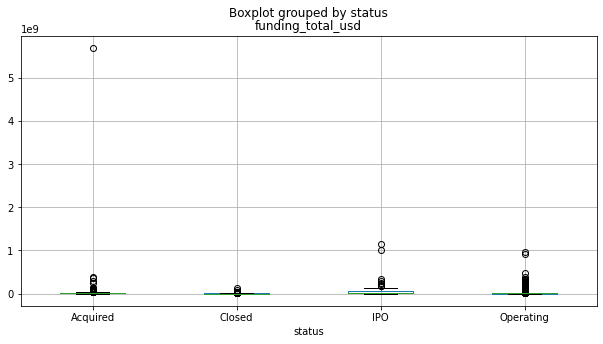

In [ ]:
df_train_aov = clean_cb[clean_cb.category_code.isin(tech)].copy().sort_values(by="funding_total_usd", ascending=False)
df_train_aov = df_train_aov[['status','first_funding_at', 'funding_rounds','funding_total_usd']]
df_train_aov['funding_rounds'] = df_train_aov['funding_rounds'].astype('int')
df_train_aov['status'] = [cat_map[x] for x in df_train_aov['status']]
df_train_aov.boxplot(column='funding_total_usd',by='status',figsize=(10,5))
plt.savefig('anova_status.eps', format='eps')
plt.show()

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


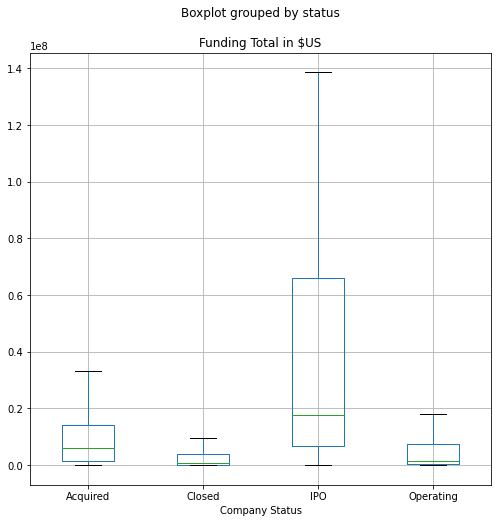

In [ ]:
df_train_aov.boxplot(column='funding_total_usd',by='status',figsize=(8,8), showfliers=False)
plt.title("Funding Total in $US")
plt.xlabel("Company Status")
plt.savefig('anova_status_nout.eps', format='eps')
plt.show()

In [ ]:
# Run an ANOVA analysis (Explain variance by status)
aov_model = ols("funding_total_usd ~ status",data=df_train_aov).fit()
aov_table = sm.stats.anova_lm(aov_model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
status,4.503534e+17,3.0,21.328343,9.842612e-14
Residual,3.978114e+19,5652.0,NaN,NaN


In [ ]:
# Run an ANOVA analysis (Explain variance by status)
aov_model = ols("funding_rounds ~ status",data=df_train_aov).fit()
aov_table = sm.stats.anova_lm(aov_model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
status,78.980474,3.0,17.518458,2.563368e-11
Residual,8493.853331,5652.0,NaN,NaN


In [ ]:
# Run an ANOVA analysis (Explain variance by year of first round of funding)
aov_model = ols("funding_total_usd ~ first_funding_at",data=df_train_aov).fit()
aov_table = sm.stats.anova_lm(aov_model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
first_funding_at,3.502049e+19,1848.0,13.844644,0.0
Residual,5.211003e+18,3807.0,NaN,NaN


In [ ]:
# Run an ANOVA analysis (Explain variance by year of first round of funding)
aov_model = ols("funding_rounds ~ first_funding_at",data=df_train_aov).fit()
aov_table = sm.stats.anova_lm(aov_model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
first_funding_at,3502.106094,1848.0,1.422787,1.629438e-19
Residual,5070.727711,3807.0,NaN,NaN


## Modeling

**We'll consolidate some of the categories to have broader categories to analyze.**

In [ ]:
# Filter dataframe based on the selected category
df_train = df_clean_cb_gdp_rsi[df_clean_cb_gdp_rsi.category_code.isin(health)].copy()
#df_train = df_clean_cb_gdp_rsi.copy()
print(df_clean_cb_gdp_rsi.shape, df_train.shape)

(15460, 24) (2354, 24)


In [ ]:
# Review the distribution of classes
df_train.groupby(by='status').count()['other']/df_train.shape[0]

status
0    0.041206
1    0.020816
2    0.030586
3    0.907392
Name: other, dtype: float64

In [ ]:
# Create features & target and split dataset
X = df_train.drop(['status','category_code'], axis=1).copy()
y = df_train['status'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Conver to lgb datasets
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test)

**We have to create a custom evaluation metric to calculate the f1-score on multiple classes.**

In [ ]:
def multiclass_f1(preds, df_train):
    """
    Custom multiclass f1-score
    :param preds: Predictions for each observation
    :param df_train: Training dataset
    """
    labels = df_train.get_label()
    preds = preds.reshape(4, -1).T
    preds = preds.argmax(axis = 1)
    f_score = f1_score(labels , preds,  average = 'weighted')
    return 'f1_score', f_score, True

**Train the model**

In [ ]:
# Define Params
params = {'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'metric': 'multi_logloss',
          'num_class':4,
          'min_data_in_leaf':300,
          'feature_fraction':0.8,
          'bagging_fraction':0.8,
          'bagging_freq':5,
          'max_depth':8,
          'num_leaves':70,
          'learning_rate':0.04}

# Train model
gbm = lgb.train(params, 
                lgb_train,
                feval=multiclass_f1,
                num_boost_round=500,
                valid_sets=[lgb_train, lgb_test],
                early_stopping_rounds=10)

#### Interpretability

Now we'll use SHAP values to understand the marginal contribution of each variable w.r. to the predicted outcome.

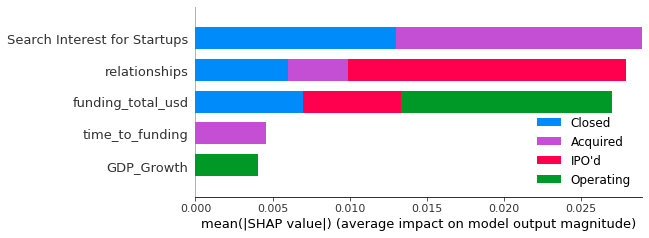

In [ ]:
#[0, 1, 2, 3] = ['acquired', 'closed', 'ipo', 'operating']
# Relationships = "Representation of the people involved in the team for that startup"
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, class_names=["Acquired", "Closed", "IPO'd", "Operating"], max_display=5)

In [ ]:
# Save SHAP values
with open("tech_shap.txt", "wb") as fp:   #Pickling
  pickle.dump(shap_values, fp)

with open("tech_shap.txt", "rb") as fp:   # Unpickling
  d = pickle.load(fp)